In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import cftime
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')

In [2]:
def calc_ox_trends(ds,startday,endday):
    hovmol=ds
    #hovmol=hovmol.where(hovmol!=-0.9999,np.nan)
    hm=hovmol.interpolate_na(dim='time').sel(time=slice(startday,endday))
    months=hm.time

    dt_dates=pd.to_numeric(months.values.astype('datetime64[D]'))
    num_dates=dt_dates
    hm['time']=num_dates

    #This will calculate the per pixel trends and pvalues

    time=hm.time.values
    xx=np.concatenate(hm.T)

    tr=[]
    pv=[]
    
    
    for i in range(xx.shape[0]):
        #Add a bit of logic to mask the arrays and if they are empty just fill it with nans.
        x=xx[i,:]
        y=time

        x=np.ravel(x)
        y=np.ravel(y)
        mask=~np.isnan(x)
        x=x[mask]
        y=y[mask]
        if len(x)!=0:
            stat=linregress(y,x)
            tr.append(stat.slope*365)
            pv.append(stat.pvalue)
        else:
            #Fill that row with nans
            stat=linregress(xx[i,:],time)
            tr.append(stat.slope*365)
            pv.append(stat.pvalue)


    tr=np.array(tr).reshape(len(hm.lon),len(hm.lat)).T
    pv=np.array(pv).reshape(len(hm.lon),len(hm.lat)).T

    hh=hm.copy()
    hh=hh.drop('time')
    hh['trend']=(['lat','lon'],tr)
    hh['pval']=(['lat','lon'],pv)
    return hh

In [3]:
# Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=16)
#cluster.adapt(minimum=2, maximum=16)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.148:37039,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [14]:
cluster.scale(cores=2)

<Client: 'tcp://127.0.0.1:38667' processes=2 threads=2, memory=5.62 GiB>

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43521")
client

<Client: 'tcp://127.0.0.1:43521' processes=16 threads=16, memory=44.92 GiB>

<Client: 'tcp://127.0.0.1:43737' processes=8 threads=8, memory=22.46 GiB>

In [2]:
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20))
#eqpac.time
eqpac

,Array,Chunk
Bytes,214.49 GiB,18.30 MiB
Shape,"(720, 96, 50, 98, 170)","(1, 96, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,214.49 GiB,18.30 MiB
Shape,"(720, 96, 50, 98, 170)","(1, 96, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [5]:
var='o2' #no3, fe
lat=-7.5
ensemble=25

In [6]:
ox_ew_pac=eqpac[var].sel(ensemble=ensemble).sel(st_ocean=slice(0,1300))
ox_ew_pac['st_ocean']=ox_ew_pac['st_ocean']*-1
#nitrate_ew_pac.load()
#nitrate_ew_pac
ox_ew_pac_all=ox_ew_pac.mean(dim='time').sel(lat=lat,method='nearest')
#nitrate_ew_pac2020=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(2000, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time').sel(lat=lat,method='nearest')
#nitrate_ew_pac_tdiff=nitrate_ew_pac2020-nitrate_ew_pac80

In [7]:
ox_ew_pac_all

<xarray.DataArray 'o2' (st_ocean: 32, lon: 170)>
dask.array<getitem, shape=(32, 170), dtype=float32, chunksize=(3, 170), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 ... -1.131e+03 -1.29e+03
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
    lat       float64 -7.5

In [8]:
client

<Client: 'tcp://10.0.128.148:37039' processes=16 threads=16, memory=119.20 GiB>

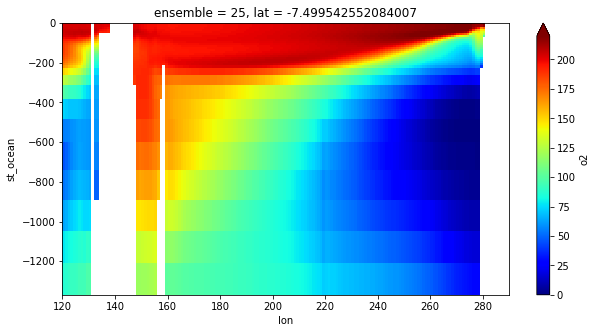

In [9]:
plt.figure(figsize=(10,5))
ox_ew_pac_all.plot(cmap='jet',vmin=0,vmax=220)

In [10]:
cluster.scale(cores=2)

In [6]:
nitrate_ew_pac=eqpac[var].sel(ensemble=ensemble).sel(st_ocean=slice(0,1000))
nitrate_ew_pac['st_ocean']=nitrate_ew_pac['st_ocean']*-1
#nitrate_ew_pac.load()
#nitrate_ew_pac
nitrate_ew_pac80=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(1960, 1, 1),cftime.DatetimeJulian(1980, 12, 31))).mean(dim='time').sel(lat=lat,method='nearest')
nitrate_ew_pac2020=nitrate_ew_pac.sel(time=slice(cftime.DatetimeJulian(2000, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time').sel(lat=lat,method='nearest')
nitrate_ew_pac_tdiff=nitrate_ew_pac2020-nitrate_ew_pac80

In [8]:
nitrate_ew_pac80

<xarray.DataArray 'o2' (st_ocean: 30, lon: 170)>
dask.array<mean_agg-aggregate, shape=(30, 170), dtype=float32, chunksize=(3, 170), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
    lat       float64 0.1662

In [ ]:
nitrate_ew_pac80.plot(vmin=0,vmax=200)
plt.show()
nitrate_ew_pac2020.plot(vmin=0,vmax=200)
plt.show()
nitrate_ew_pac_tdiff.plot(vmin=-75,vmax=75,cmap='bwr')
plt.show()

In [10]:
ox250m=eqpac['o2'].sel(st_ocean=250,ensemble=ensemble,method='nearest')
ox250Pac_70_90=ox250m.sel(time=slice(cftime.DatetimeJulian(1970, 1, 1),cftime.DatetimeJulian(1992, 12, 31))).mean(dim='time')
ox250Pac_00_20=ox250m.sel(time=slice(cftime.DatetimeJulian(2000, 1, 1),cftime.DatetimeJulian(2019, 12, 31))).mean(dim='time')

In [11]:
ox250Pac_70_90

<xarray.DataArray 'o2' (lat: 98, lon: 170)>
dask.array<mean_agg-aggregate, shape=(98, 170), dtype=float32, chunksize=(98, 170), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
    st_ocean  float64 241.3
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36

In [12]:
ox250Pac_00_20

<xarray.DataArray 'o2' (lat: 98, lon: 170)>
dask.array<mean_agg-aggregate, shape=(98, 170), dtype=float32, chunksize=(98, 170), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
    st_ocean  float64 241.3
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36

Text(0.5, 1.0, 'O2 Concentration and OMZ Boundary at 241m depth 2000-2020 mean (mmol/m^3)')

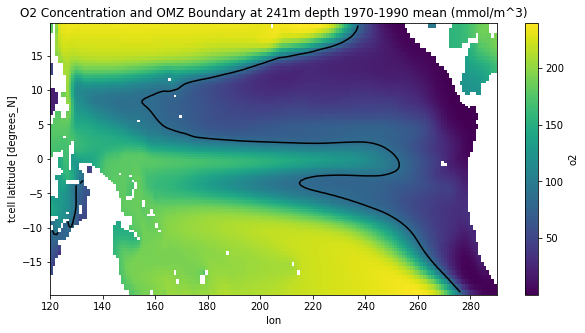

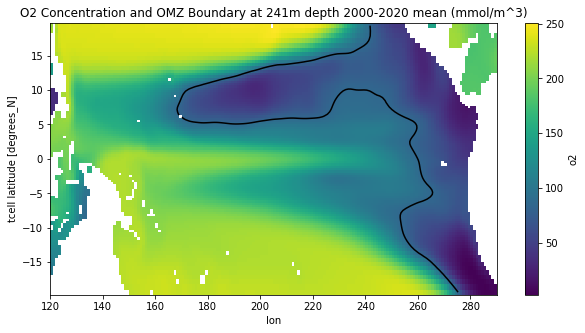

In [51]:
plt.figure(figsize=(10,5))
ox250Pac_70_90.plot()
ox250Pac_70_90.plot.contour(levels=[85],colors='k')
plt.title('O2 Concentration and OMZ Boundary at 241m depth 1970-1990 mean (mmol/m^3)')

plt.figure(figsize=(10,5))
ox250Pac_00_20.plot()
ox250Pac_00_20.plot.contour(levels=[85],colors='k')
plt.title('O2 Concentration and OMZ Boundary at 241m depth 2000-2020 mean (mmol/m^3)')

In [53]:
ox100_1000m=eqpac['o2'].sel(st_ocean=slice(100,1000),ensemble=ensemble).mean(dim='st_ocean')
ox100_1000mPac_70_90=ox100_1000m.sel(time=slice(cftime.DatetimeJulian(1970, 1, 1),cftime.DatetimeJulian(1992, 12, 31)))#.mean(dim='time')
ox100_1000mPac_00_20=ox100_1000m.sel(time=slice(cftime.DatetimeJulian(2000, 1, 1),cftime.DatetimeJulian(2019, 12, 31)))#.mean(dim='time')

In [54]:
ox100_1000mPac_70_90_trend=ox100_1000mPac_70_90.polyfit(dim='time',deg=1).polyfit_coefficients.sel(degree=1)*1e9*60*60*24*365.25*10 #From Nanoseconds to Year to Decade
ox100_1000mPac_00_20_trend=ox100_1000mPac_00_20.polyfit(dim='time',deg=1).polyfit_coefficients.sel(degree=1)*1e9*60*60*24*365.25*10 #From Nanoseconds to Year to Decade
ox100_1000mPac_trend=ox100_1000m.polyfit(dim='time',deg=1).polyfit_coefficients.sel(degree=1)*1e9*60*60*24*365.25*10 #From Nanoseconds to Year to Decade

Text(0.5, 1.0, '100-1000m, 1960-2020 O2 Trend (mmol/m^3)/Decade')

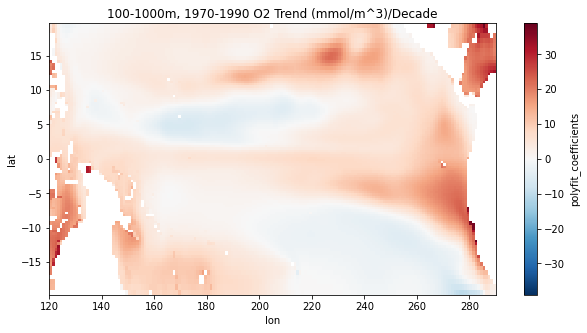

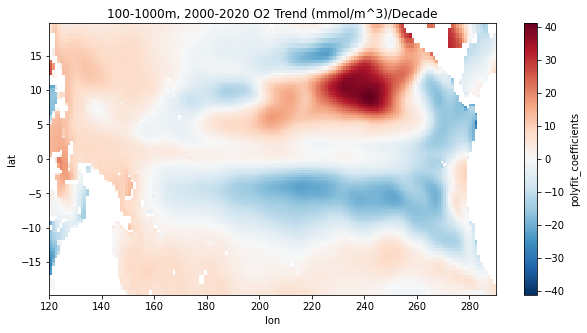

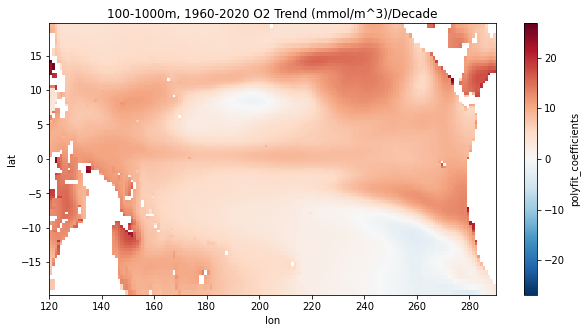

In [55]:
plt.figure(figsize=(10,5))
ox100_1000mPac_70_90_trend.plot()
plt.title('100-1000m, 1970-1990 O2 Trend (mmol/m^3)/Decade')

plt.figure(figsize=(10,5))
ox100_1000mPac_00_20_trend.plot()
plt.title('100-1000m, 2000-2020 O2 Trend (mmol/m^3)/Decade')

plt.figure(figsize=(10,5))
ox100_1000mPac_trend.plot()
plt.title('100-1000m, 1960-2020 O2 Trend (mmol/m^3)/Decade')

In [58]:
cluster.scale(cores=16)

In [65]:
cluster

In [66]:
ox_all=eqpac['o2'].sel(st_ocean=slice(100,1000),ensemble=ensemble).mean(dim='st_ocean')
ox_allPac_70_90=ox_all.sel(time=slice(cftime.DatetimeJulian(1970, 1, 1),cftime.DatetimeJulian(1992, 12, 31)))#.mean(dim='time')
ox_allPac_00_20=ox_all.sel(time=slice(cftime.DatetimeJulian(2000, 1, 1),cftime.DatetimeJulian(2019, 12, 31)))#.mean(dim='time')

In [67]:
ox_allPac_70_90_trend=ox_allPac_70_90.polyfit(dim='time',deg=1).polyfit_coefficients.sel(degree=1)*1e9*60*60*24*365.25*10 #From Nanoseconds to Year to Decade
ox_allPac_00_20_trend=ox_allPac_00_20.polyfit(dim='time',deg=1).polyfit_coefficients.sel(degree=1)*1e9*60*60*24*365.25*10 #From Nanoseconds to Year to Decade
ox_allPac_trend=ox_all.polyfit(dim='time',deg=1).polyfit_coefficients.sel(degree=1)*1e9*60*60*24*365.25*10 #From Nanoseconds to Year to Decade

Text(0.5, 1.0, '0-5000m+, 1960-2020 O2 Trend (mmol/m^3)/Decade')

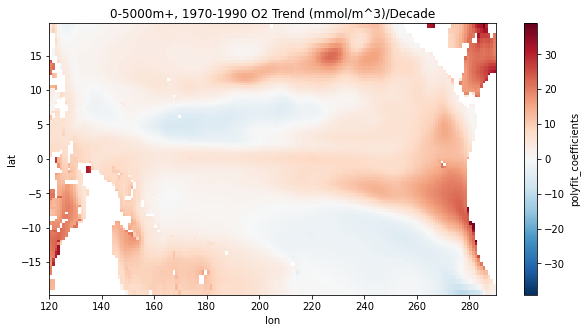

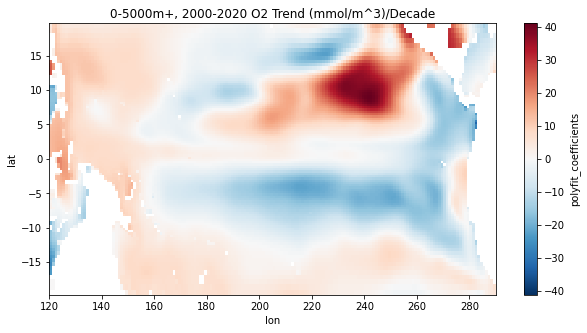

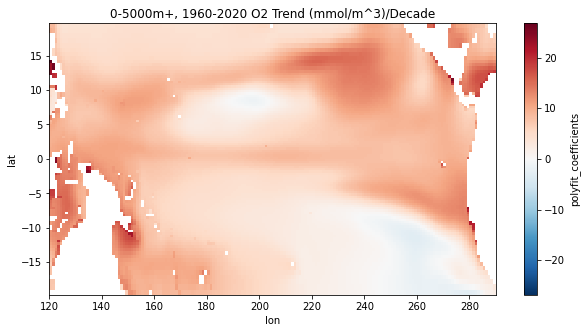

In [68]:
plt.figure(figsize=(10,5))
ox_allPac_70_90_trend.plot()
plt.title('0-5000m+, 1970-1990 O2 Trend (mmol/m^3)/Decade')

plt.figure(figsize=(10,5))
ox_allPac_00_20_trend.plot()
plt.title('0-5000m+, 2000-2020 O2 Trend (mmol/m^3)/Decade')

plt.figure(figsize=(10,5))
ox_allPac_trend.plot()
plt.title('0-5000m+, 1960-2020 O2 Trend (mmol/m^3)/Decade')

In [69]:
cluster.scale(cores=2)

In [70]:
cluster

In [71]:
np.arange(0,8,1)

array([0, 1, 2, 3, 4, 5, 6, 7])